![DSME-logo](../img/DSME_logo.png)

#  Reinforcement Learning and Learning-based Control

<p style="font-size:12pt";> 
<b> Prof. Dr. Sebastian Trimpe, Dr. Friedrich Solowjow </b><br>
<b> Institute for Data Science in Mechanical Engineering (DSME) </b><br>
<a href = "mailto:rllbc@dsme.rwth-aachen.de">rllbc@dsme.rwth-aachen.de</a><br>
</p>

---

# On-Policy vs. Off-Policy TD-Control for CliffWalking
(Adapted from Sutton & Barto Example 6.6)

## Imports

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import custom_envs
import copy
from IPython.display import Video
from IPython.display import display
from matplotlib.animation import FuncAnimation

## Design of the Agent
The CliffWalking environment is a gridworld example that requires the agent to find an optimal path to receive a reward. This is a standard undiscounted, episodic task, with start and goal states, and actions causing movement up, down, right, and left.
Reward is −1 on all transitions except those into the "cliff", causing the agent to fall. Stepping into this region incurs a reward of −100 and sends the agent instantly back to the start. 

<img src="./img/cliff_walking.gif" alt="Example of Cliff_Walking" width="500">   

The agent is capable of two different learning algorithms:
Sarsa and Q-learning, highlighting the difference between on-policy (Sarsa) and off-policy (Q-learning) methods.

In [2]:
class TD_Agent():
    def __init__(self, env, gamma=1.0, learning_rate=0.05, epsilon=0.1):
        self.env = env
        self.action_value_fn = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon

    def get_random_action(self):
        random_action = np.random.choice(range(self.env.action_space.n))
        return random_action
    def get_best_action(self, obs):
        best_action = np.random.choice(np.flatnonzero(np.isclose(self.action_value_fn[obs], self.action_value_fn[obs].max(),
                                                                 rtol=0.01)))
        return best_action
    def epsilon_greedy_policy(self, obs):
        # returns action, choosing a random action with probability epsilon or the best action based on Q(s,a)
        randomly = np.random.random() < self.epsilon
        if randomly:
            action = self.get_random_action()
        else:
            action = self.get_best_action(obs)
        return action

    def q_learning(self, num_episodes):
        returns = []
        for i in range(num_episodes):
            returns_i = 0
            obs, info = env.reset()
            done = False
            while not done:
                action = self.epsilon_greedy_policy(obs)
                next_obs, reward, done, truncated, info = env.step(action)
                best_next_action = self.get_best_action(next_obs)
                td_target = reward + self.gamma * self.action_value_fn[next_obs][best_next_action]
                update = (1-self.learning_rate) * self.action_value_fn[obs][action] + self.learning_rate * td_target
                self.action_value_fn[obs][action] = update
                obs = next_obs
                returns_i += reward
            returns.append(returns_i)
        return returns

    def sarsa(self, num_episodes):
        returns = []
        for i in range(num_episodes):
            returns_i = 0
            obs, info = env.reset()
            action = self.epsilon_greedy_policy(obs)
            done = False
            while not done:
                next_obs, reward, done, truncated, info = env.step(action)
                next_action = self.epsilon_greedy_policy(next_obs)
                td_target = reward + self.gamma * self.action_value_fn[next_obs][next_action]
                update = (1-self.learning_rate) * self.action_value_fn[obs][action] + self.learning_rate * td_target
                self.action_value_fn[obs][action] = update
                obs = next_obs
                action = next_action
                returns_i += reward
            returns.append(returns_i)
        return returns

    def reset(self):
        self.action_value_fn = np.zeros((self.env.observation_space.n, self.env.action_space.n))

## Evaluation of the Training
To compare the two methods, both agents are trained with the same properties. Epsilon is set to 0.1, allowing for occasional random behavior of the agent, and the training lasts for 8000 episodes. The function used for comparison can be found below:

In [3]:
    def evaluate(self, env, num_runs=1, file=None):
        frames = []  # collect rgb_image of agent env interaction
        video_created = False
        tot_reward = [0]
        for _ in range(num_runs):
            done = False
            obs, info = env.reset()
            reward_per_run = 0
            while not done:
                action = self.get_best_action(obs)
                obs, reward, done, truncated, info = env.step(action)
                reward_per_run += reward
                # save frame
                out = env.render()
                frames.append(out)
            tot_reward.append(reward_per_run + tot_reward[-1])

        # create animtation out of saved frames
        if all(frame is not None for frame in frames):
            fig = plt.figure(figsize=(10, 6))
            plt.axis('off')
            img = plt.imshow(frames[0])

            def animate(index):
                img.set_data(frames[index])
                # plt.show()
                return [img]
            anim = FuncAnimation(fig, animate, frames=len(frames), interval=20)
            plt.close()
            anim.save(file, writer="ffmpeg", fps=5)
            video_created = True

        return tot_reward, video_created
    
setattr(TD_Agent, "evaluate", evaluate)

We show the return of both agents over the episodes. To allow for improved visualization, the returns are smoothed using the following function:

In [4]:
def smooth(array, size):
    window_size = size
    filter = np.ones(window_size) / window_size
    smoothed_array = np.convolve(array, filter, mode='same')
    return smoothed_array

In the diagram below, the smoothed returns are displayed. Although both agents learn and improve their policy over time, Q-learning receives significantly less reward during training.

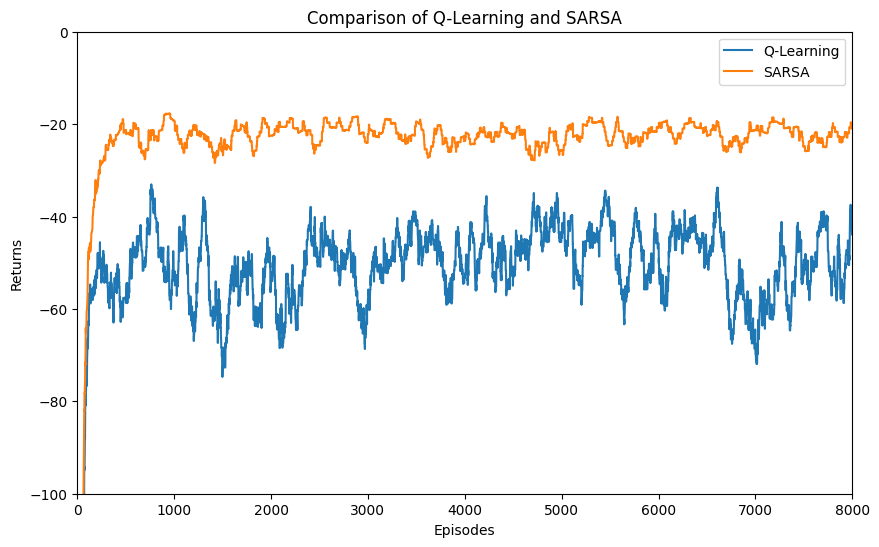

In [5]:
# Train the agents
env = gym.make('CliffWalking-v1', render_mode=None)
num_episodes = 8100
filter = 100
env.reset()
agent = TD_Agent(env, gamma=0.9, learning_rate=0.1, epsilon=0.1)
q_learning_training_history = smooth(agent.q_learning(num_episodes=num_episodes), filter)
q_learning_agent = copy.deepcopy(agent)
agent.reset()
sarsa_training_history = smooth(agent.sarsa(num_episodes=num_episodes), filter)
sarsa_agent = copy.deepcopy(agent)
agent.reset()

# Compare the returns
fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure and an axes.
ax.plot(range(num_episodes), q_learning_training_history, label="Q-Learning")
ax.plot(range(num_episodes), sarsa_training_history, label="SARSA")
ax.grid(False)
ax.set_xlabel('Episodes')
ax.set_ylabel('Returns')
ax.set_title("Comparison of Q-Learning and SARSA")
ax.set_ylim(-100, 0)
ax.set_xlim(0, num_episodes-filter)
ax.legend()
plt.show()

This significant difference in the returns results from the epsilon-greedy training and the on-/off-policy characteristics of the agents. Below, we visualize the final policies in the environment, were exploratory actions are no longer taken.<br>
The agent trained using Q-learning learns the values for the target policy, which travels right along the edge of the cliff. Unfortunately, this results in
its occasionally falling off the cliff during training due to the ε-greedy action exploration, which causes the reduced returns during training.<br>
Sarsa, on the other hand, learns values for the behavior policy and thus takes random exploratory actions into account. Therefore, it learns the longer but safer path through the upper part of the grid. 

# Q-learning agent:

In [6]:
render_env = gym.make('CliffWalking-v1', render_mode='rgb_array')
print('Q-Learning agent:')
video_file_1 = "q_learning.mp4"
q_learning_agent.evaluate(render_env, 5, video_file_1)
Video(video_file_1, html_attributes="loop autoplay")

Q-Learning agent:


In [7]:
print('SARSA agent:')
video_file_2 = "sarsa.mp4"
sarsa_agent.evaluate(render_env, 5, video_file_2)
Video(video_file_2, html_attributes="loop autoplay")

SARSA agent:
